### Attempt Numero Uno

In [1]:
from scipy import optimize
import numpy as np
from matplotlib import pyplot as plt
import seaborn


"""
This OLG Model calculates the time path and steady state for s periods, with 
labor endogenous, stationarizied population and GDP growth, and Taxes.

#### Paramaters ###
beta   = discount factor, (0,1)**years per period
delta   = depreciation, (0,1)**years per period
gamma    = consumption relative risk averstion, <1
sigma    = labor relative risk aversion, <1
alpha    = cobb-douglas ouput elasticity of labor (0,1)
A        = Firm productivity coeffecient >0
periods  = number of periods you wish to use (3,80)
years    = number of years per period (1,20)
error    = Intializes an error for the TPI >5
xi       = Used to calculate your convex combonation for TPI
epsilon  = Accuracy parameter in TPI calculation
T        = Number of periods to reach the steady state, should be large
shock    = How much to shock the economy away from the Steady State

guess_vector = intial guess for the cap fsolve. The first s entries are capital guess, the last s entries are labor guesses
"""

### Paramaters ###
periods = 60
years = 60./periods
beta = .96**years
delta = 1-(1-.05)**years
gamma = 2.9
alpha = .35 # Labor Capital split in Cobb-Doublas
sigma = 2.9 
A = 1 # Production multiplier
xi = .5 # Convex combination constant
epsilon = 10e-9 # tolerance
T = 50 
shock = .9 # Shock to GDP


labor_guess = .8
cap_guess = .1
error = 1.


guess_vector = np.ones(2*periods-1)*cap_guess
guess_vector[-periods:] = labor_guess

def wage (kvector, lvector):
    market_k = np.sum(kvector)
    market_l = np.sum(lvector)
    
    w = (1-alpha)*A*((market_k)/market_l)**(alpha)
    return w

def rate (kvector, lvector): 
    market_k = np.sum(kvector)
    market_l = np.sum(lvector)
    
    r = (alpha)*A*(market_l/(market_k))**(1-alpha)
    return r

def cap(guess_vector):
    """
    This takes the Euler equations, and sets them equal to zero for an f-solve
    Remember that Keq was found by taking the derivative of the sum of the 
        utility functions, with respect to k in each time period, and that 
        leq was the same, but because l only shows up in 1 period, it has a
        much smaller term.

    ### Paramaters ###
    guess_vector: The first half is the intial guess for the kapital, and
        the second half is the intial guess for the labor
    """
    
    #equations for keq
    ks = np.zeros(periods)
    ks[1:] = guess_vector[:periods-1]
    ls  = guess_vector[periods-1:]
    kk  = ks[:-1]
    kk1 = ks[1:]
    kk2 = np.zeros(periods-1)
    kk2[:-1] = ks[2:]
    lk  = ls[:-1]
    lk1 = ls[1:]
    
    #equation for leq
    ll = np.copy(ls)
    kl = np.copy(ks)
    kl1 = np.zeros(periods)
    kl1[:-1] = kl[1:]
    w = wage(ks, ls)
    r = rate(ks, ls)
    keq = ((lk*w+(1.+r-delta)*kk - kk1)**-gamma - (beta*(1+r-delta)*(lk1*w+(1+r-delta)*kk1-kk2)**-gamma))
    leq = ((w*(ll*w + (1+r-delta)*kl-kl1)**-gamma)-(1-ll)**-sigma)
    error = np.append(keq, leq)

    return np.append(keq, leq)






In [2]:
ssvalue = optimize.fsolve(cap, guess_vector)
kbars = np.zeros(periods -1)
kbars = ssvalue[:periods-1]
lbars = np.zeros(periods)
lbars = ssvalue[periods-1:]
print 'Capital steady state values: {}'.format(kbars)
print 'Labor steady state values: {}'.format(lbars)
wbar =  wage(kbars, lbars)
rbar = rate(kbars, lbars)
print("Wage steady state: ", wbar)
print("Rate stead state: ", rbar)
Kss = np.sum(kbars)
Lss = np.sum(lbars)
print('Market Capital steady state: ', Kss)
print('Market Labor steady state: ', Lss)
K0 = Kss*shock
kshock = kbars*shock

Capital steady state values: [ 0.11235717  0.22471973  0.33700749  0.44913326  0.56100226  0.67251153
  0.78354929  0.89399425  1.0037148   1.11256829  1.22040007  1.3270426
  1.43231439  1.53601895  1.63794355  1.73785798  1.83551318  1.93063969
  2.02294615  2.11211746  2.19781301  2.27966461  2.35727436  2.43021229
  2.49801384  2.56017716  2.61616017  2.66537737  2.7071965   2.7409348
  2.76585508  2.78116142  2.78599459  2.77942707  2.76045769  2.72800584
  2.68090523  2.61789722  2.5376235   2.43861834  2.31930012  2.17796223
  2.01276334  1.82171674  1.60267902  1.35333771  1.07119811  0.7535689
  0.39754682]
Labor steady state values: [ 0.5420845   0.53788936  0.53365578  0.52938342  0.52507192  0.52072091
  0.51633005  0.51189896  0.50742728  0.50291462  0.49836063  0.49376491
  0.4891271   0.48444679  0.4797236   0.47495715  0.47014702  0.46529283
  0.46039417  0.45545063  0.4504618   0.44542726  0.4403466   0.4352194
  0.43004522  0.42482364  0.41955423  0.41423653  0.408870

In [3]:


#################### Exercises 3,4 ##############################

def wage_path(K_guess,L_guess):
    return list((1-alpha)*(K_guess/L_guess)**alpha)

def rate_path(K_guess, L_guess):
    path = list(alpha*(L_guess/K_guess)**(1-alpha))
    return path

def L2_norm_func(path1, path2):
    dif = path1 - path2
    sq = dif ** 2
    summed = sq.sum()
    rooted = summed ** .5
    return rooted

def TPI_Euler(guess, wage, rate, kbars, counter):
    '''
    This is a period general version of the equations, that will take in vectors
    for each of the values, and return the same number of equations to optimize. 
    K_guess will be the capital values thus calculated,
    wage will be the wage vector that we can pull wage1, wage2 from
    rate will be the rate vector that we can pull rate1 and rate2 from
    '''

    kbars = np.append(np.array([0.]),kbars)
    k_guess = guess[:counter-1]
    l_guess = guess[counter-1:]
    wage1 = wage[:counter-1]
    wage2 = wage[1:counter]
    rate1 = rate[:counter-1]
    rate2 = rate[1:counter]
    k1 = np.zeros(counter-1)
    k1[0] = kbars[-counter]
    k2 = np.copy(k_guess)
    k3 = np.zeros(counter-1)
    if counter >2: 
        k1[1:] = k_guess[:-1]
        k3[:-1] = k_guess[1:]
    l1 = l_guess[:-1]
    l2 = l_guess[1:]
    w = wage[:counter]
    l = np.copy(l_guess)
    r = rate[:counter]
    lk1 = np.append(k1, k_guess[-1])
    lk2 = np.append(k2, 0)



    error1 = ((l1*wage1 + (1+rate1 - delta)*k1-k2)**-gamma - beta * (1+rate2 - delta) * 
            (wage2*l2 + (1+rate2 - delta)*k2 - k3)**-gamma)
    error2 = w*(l*w + (1+r-delta)*lk1-lk2)**-gamma-(1-l)**-gamma

    return np.append(error1, error2)

def TPI_Euler_2(guess, wage, rate, K_guess_init, counter):
    '''
    This is a period general version of the equations, that will take in vectors
    for each of the values, and return the same number of equations to optimize. 
    K_guess will be the capital values thus calculated,
    wage will be the wage vector that we can pull wage1, wage2 from
    rate will be the rate vector that we can pull rate1 and rate2 from
    '''

    k_guess = guess[:periods-1] 
    l_guess = guess[periods-1:]
    wagess = np.ones(periods + T + 2) * wage[-1]
    ratess = np.ones(periods + T + 2) * rate[-1]
    wagess[:T] = wage
    ratess[:T] = rate
    wage = wagess
    rate = ratess
    wage1 = np.ones(periods-1) * wage[-1]
    wage2 = np.ones(periods-1) * wage[-1]
    wage1 = wage[counter:periods + counter-1]
    wage2 = wage[1+counter:periods+counter]
    rate1 = np.ones(periods-1) * rate[-1]
    rate2 = np.ones(periods-1) * rate[-1]
    rate1 = rate[counter:periods-1 + counter]
    rate2 = rate[1+counter:periods+counter]
    k1 = np.zeros(periods-1)
    k1[1:] = k_guess[:-1]
    k2 = np.copy(k_guess)
    k3 = np.zeros(periods-1)
    k3[:-1] = k_guess[1:]
    l1 = l_guess[:-1]
    l2 = l_guess[1:]
    w = wage[counter+1:counter+1+periods]
    l = np.copy(l_guess)
    r = rate[counter+1:counter+1+periods]
    lk1 = np.append(k1, k_guess[-1])
    lk2 = np.append(k2, 0)

    error1 = ((l1*wage1 + (1+rate1 - delta)*k1-k2)**-gamma - beta * (1+rate2 - delta) * 
            (wage2*l2 + (1+rate2 - delta)*k2 - k3)**-gamma)
    error2 = w*(l*w + (1+r-delta)*lk1-lk2)**-gamma-(1-l)**-gamma

    return np.append(error1, error2)

def Scaler_Euler(labor, wage, rate, kap):
    return wage*(labor*wage + (1+rate-delta)*kap)**-gamma-(1-labor)**-gamma

print 'Working on TPI...'
K_new = np.linspace(K0, Kss, T)
L_new = np.ones(T)*Lss
iters = 0
while error > epsilon:
    iters += 1
    counter = 2
    K_old = np.copy(K_new)
    L_old = np.copy(L_new)
    wage_guess = np.asarray(wage_path(K_new,L_new))
    rate_guess = np.asarray(rate_path(K_new,L_new))
    K_matrix = np.zeros((T+periods,periods-1))
    K_matrix[0,:] = kshock
    L_matrix = np.zeros((T+periods,periods))
    lcorner = optimize.fsolve(Scaler_Euler, lbars[-1], args =(wage_guess[0], rate_guess[0], kbars[-1]))
    L_matrix[0,-1] = lcorner
    while counter <= periods:
        guess = np.ones(counter*2-1)
        guess[:counter-1] = kbars[periods-counter:]
        guess[counter-1:] = lbars[periods-counter:]
        newvec = optimize.fsolve(TPI_Euler, guess, args = (wage_guess, rate_guess, kshock, counter))
        newk = newvec[:counter-1]
        newl = newvec[counter-1:]
        if counter == periods:
            K_matrix[:periods,:] += np.diag(newk, -1)[:,:-1]
        else:
            K_matrix[1:periods-1, 1:] += np.diag(newk, periods-1-counter)
        L_matrix[:periods,:] += np.diag(newl, periods-counter)
        counter +=1

    for t_period in xrange(T):
        guess = np.ones(periods*2-1)
        guess[:periods-1] = kbars
        guess[periods-1:] = lbars
        newvec = optimize.fsolve(TPI_Euler_2, guess, args = (wage_guess, rate_guess, K_new, t_period))
        newk = newvec[:periods-1]
        newl = newvec[periods-1:]
        K_matrix[t_period+2:periods+t_period+1, :periods] += np.diag(newk, 0)
        L_matrix[t_period+1:periods+t_period+1, :periods]+= np.diag(newl, 0)
        t_period += 1

    K_new = K_matrix.sum(axis = 1)
    K_new = K_new[:T]
    L_new = L_matrix.sum(axis = 1)
    L_new = L_new[:T]
    Kerror = L2_norm_func(K_new, K_old)
    Lerror = L2_norm_func(L_new, L_old)
    error = max(Kerror, Lerror)

    print error
    if error > epsilon:
        K_new = xi * K_new + (1-xi) * K_old
        L_new = xi * L_new + (1-xi) * L_old



Working on TPI...
64.481430862
53.5563475123
52.7782404123
47.0817516766
42.3578159794
36.808326899
32.3529938668
27.9409883549
24.4133313447
21.0752448798
18.3710027925
15.8706437459
13.8149872362
11.9444580445
10.3872337037
8.98702770745
7.8097908483
6.76071798996
5.87199516193
5.08536446177
4.41512594766
3.82489185784
3.31979906798
2.87669564844
2.49626412576
2.16348026585
1.87705785562
1.62704933176
1.41146968677
1.22360259922
1.06137977577
0.920182886276
0.798131102751
0.69199598931
0.600179122153
0.520391032248
0.451325637043
0.39133948048
0.33939153874
0.294290175054
0.255219262984
0.221307712062
0.191922978227
0.166424151292
0.144324917856
0.125151315444
0.108531619504
0.0941139358232
0.0816153252635
0.0707737227055
0.0613744340812
0.053221833843
0.0461533842209
0.0400227934134
0.0347072179244
0.0300971093054
0.0260997414649
0.0226329958358
0.0196269457684
0.0170199862202
0.0147594211854
0.0127990074629
0.0110990548144
0.00962483575325
0.00834646770058
0.00723786229801
0.006276

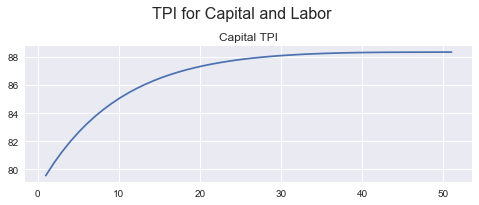

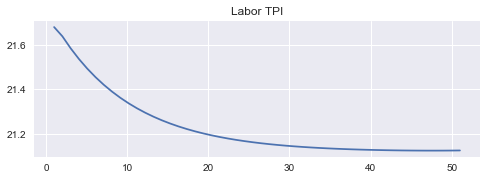

In [4]:
x = np.linspace(0,T,T)+1
fig = plt.figure()
fig.suptitle("TPI for Capital and Labor", fontsize = 16)

ax = plt.subplot("211")
ax.set_title("Capital TPI")
ax.plot(x,K_new)
plt.show()



fig = plt.figure()
ax = plt.subplot("211")
ax.set_title("Labor TPI")
ax.plot(x, L_new)
plt.show()

### Attempt Numero dos

In [ ]:
'''
Evan Magnusson
5/5/2015
OLG Homework
'''
from __future__ import division
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

'''
Exercise 3.1
Solve OLG model
'''

# Parameter Values
beta = .98 # Discount rate
delta = .6415 # depreciation
gamma = 3.0 # We called this sigma
A = 1.0 # Marginal multiplier of producition
alpha = .35 # Capital/Labor split in Cobb-Douglas production

# Functions


def ut_func(cons):
    u = ((cons) ** (1 - gamma) - 1) / (1 - gamma)
    return u


def ut_deriv_func(cons):
    u_prime = cons ** (-gamma)
    return u_prime


def c1_func(w_t, k2_t1):
    c1 = w_t - k2_t1
    return c1


def c2_func(w_t1, r_t1, k2_t1, k3_t2):
    c2 = w_t1 + (1 + r_t1 - delta) * k2_t1 - k3_t2
    return c2


def c3_func(r_t2, k3_t2):
    c3 = (1 + r_t2 - delta) * k3_t2
    return c3


def w_func(K):
    w = (1-alpha) * A * (K / 2.0) ** alpha
    return w


def r_func(K):
    r = alpha * A * (2.0 / K) ** (1 - alpha)
    return r


def K_func(k2, k3):
    K = k2 + k3
    return K


def Steady_State(list_of_ks):
    k2, k3 = list_of_ks
    K = K_func(k2, k3)
    error1 = ut_deriv_func(w_func(K) - k2) - beta * (
        1 + r_func(K) - delta) * ut_deriv_func(w_func(K) + (1 + r_func(K) - delta)*k2 - k3)
    error2 = ut_deriv_func(w_func(K) + (1 + r_func(K) - delta)*k2 - k3) - beta * (
        1+r_func(K)-delta) * ut_deriv_func((1+r_func(K) - delta)*k3)
    return [error1] + [error2]

k2_ss, k3_ss = opt.fsolve(Steady_State, [.5, .5])
K_ss = K_func(k2_ss, k3_ss)
w_ss = w_func(K_ss)
r_ss = r_func(K_ss)
c1_ss = c1_func(w_ss, k2_ss)
c2_ss = c2_func(w_ss, r_ss, k2_ss, k3_ss)
c3_ss = c3_func(r_ss, k3_ss)
print 'Exercise 1:'
print 'k2_ss:', k2_ss
print 'k3_ss:', k3_ss
print 'c1_ss:', c1_ss
print 'c2_ss:', c2_ss
print 'c3_ss:', c3_ss
print 'w_ss: ', w_ss
print 'r_ss: ', r_ss


'''
Exercise 3.2
Change parameter value of beta
'''

beta = .55
k2_ss_2, k3_ss_2 = opt.fsolve(Steady_State, [.5, .5])
K_ss_2 = K_func(k2_ss_2, k3_ss_2)
w_ss_2 = w_func(K_ss_2)
r_ss_2 = r_func(K_ss_2)
c1_ss_2 = c1_func(w_ss_2, k2_ss_2)
c2_ss_2 = c2_func(w_ss_2, r_ss_2, k2_ss_2, k3_ss_2)
c3_ss_2 = c3_func(r_ss_2, k3_ss_2)
print '\nExercise 2:'
print 'k2_ss:', k2_ss_2
print 'k3_ss:', k3_ss_2
print 'c1_ss:', c1_ss_2
print 'c2_ss:', c2_ss_2
print 'c3_ss:', c3_ss_2
print 'w_ss: ', w_ss_2
print 'r_ss: ', r_ss_2

'''
Exercise 3.3
TPI
'''
# Parameters
beta = .442
T = 70
epsilon = 1e-9
xi = .1

k2_init = .8 * k2_ss
k3_init = 1.1 * k3_ss

K_init = K_func(k2_init, k3_init)
print K_init
K_path = np.linspace(K_init, K_ss, T+1)
w_path = w_func(K_path)
r_path = r_func(K_path)
error = 10.0

# Functions


def L2_norm_func(path1, path2):
    dif = path1 - path2
    sq = dif ** 2
    summed = sq.sum()
    rooted = summed ** .5
    return rooted


def Euler_Equation_TPI_little(k3_2, w1, r1, r2, k2_1):
    error1 = ut_deriv_func(w1 + (1 + r1 - delta)*k2_1 - k3_2) - beta * (1 + r2 - delta) * ut_deriv_func((1+r2-delta)*k3_2)
    return error1


def Euler_Equation_TPI(guesses, w1, w2, r2, r3):
    k2, k3 = guesses
    error1 = ut_deriv_func(w1 - k2) - beta * (1 + r2 - delta) * ut_deriv_func(w2 + (1 + r2 - delta) * k2 - k3)
    error2 = ut_deriv_func(w2 + (1 + r2 - delta)*k2 - k3) - beta * (1 + r3 - delta) * ut_deriv_func((1 + r3 -delta) * k3)
    return [error1] + [error2]

while error > epsilon:
    k_mat = np.zeros((T+1, 2))
    k_mat[1, 1] = opt.fsolve(Euler_Equation_TPI_little, k3_init, args=(w_path[0], r_path[0], r_path[1], k2_init))
    for t in xrange(1, T):
        k_mat[t, 0], k_mat[t+1, 1] = opt.fsolve(Euler_Equation_TPI, [k2_init, k3_init], args=(w_path[t-1], w_path[t], r_path[t], r_path[t+1]))
    K_path_new = k_mat.sum(axis=1)
    K_path_new[0] = K_init
    K_path_new[-1] = K_ss
    error = L2_norm_func(K_path, K_path_new)
    if error > epsilon:
        K_path = xi * K_path_new + (1-xi) * K_path
        w_path = w_func(K_path)
        r_path = r_func(K_path)



'''
Exercise 3.4
Plot TPI
'''

time_to_converge = 0

for t in xrange(T):
    dif = np.abs(K_path[t] - K_ss)
    if dif > .0001:
        time_to_converge+=1

print "\nExercise 4"
print "Time to Converge:", time_to_converge

plt.plot(np.linspace(0, T, T), K_path[:T])
plt.title("Time path for Aggregate Capital Stock")
plt.show()
